In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
DATA = 'data'
allFiles = glob.glob(DATA + "/*.csv")
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_)
    list_.append(df)
data = pd.concat(list_)
data.index = np.arange(len(data))

In [3]:
"""
We'll ignore retweets and non-english tweets.
The `retweet` field doesn't seem to capture all retweets, so I
do a little regexing to catch the bulk of the remaining ones
"""
data = data.loc[(data.language == 'English') & (data.retweet == 0) & \
                (~data.content.str.contains(' RT\s@?[\w\_]*:').astype(bool)) & \
                (~data.content.str.startswith('RT').astype(bool))]

In [4]:
print(data.shape[0], 'tweets remaining')

1198189 tweets remaining


In [6]:
print('Random Tweet:')
ind = np.random.choice(data.index)
print(f'Tweet index: {ind}\nTweet text: {data.content[ind]}')

Random Tweet:
Tweet index: 2904747
Tweet text: District Court Drops Charges Against Illegal Alien Who Allegedly Raped Rockville Teen In School Bathroom! https://t.co/gdaWPo6Ypm https://t.co/U2GJRycRaJ


In [7]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import words
import re
from tokenizer import tokenizer
import unidecode

In [8]:
T = tokenizer.TweetTokenizer(preserve_handles=True, 
                             preserve_hashes=True, 
                             preserve_case=False, 
                             preserve_url=False,
                             regularize=True)
en_stop = set(stopwords.words('english') + ['rt'])
p_stemmer = PorterStemmer()
en_words = set(w.lower() for w in words.words())

In [9]:
def lower(x): 
    return x.lower()
def decode_uni(x):
    return unidecode.unidecode(x)
def tokenize(x): 
    return T.tokenize(x)
def rm_stop(x): 
    return [j for j in x if not j in en_stop]
def stem(x): 
    return [p_stemmer.stem(j) for j in x]
def english(x):
    return list(filter(lambda w: w in en_words, x))
def rm_noalphanum(x):
    return list(filter(lambda x: re.search(r'[A-Za-z]', x), x))
def get_hashtags(x):
    return list(filter(lambda x: x[0] == '#', x))

In [10]:
def preprocess(text, transformations=[lower, decode_uni, tokenize, rm_stop, rm_noalphanum]):
    for t in transformations:
        text = t(text)
    return text

### On The Right
Modeling topics for tweets from users classified as `RightTroll`

In [72]:
%%time
rdata = data.loc[(data.account_category == 'RightTroll')]
# rdata = data
text = rdata.content
docs = [preprocess(d) for d in text.values]

CPU times: user 1min 20s, sys: 1.05 s, total: 1min 21s
Wall time: 1min 22s


#### Top Hashtags

In [73]:
hashtags = [get_hashtags(doc) for doc in docs]

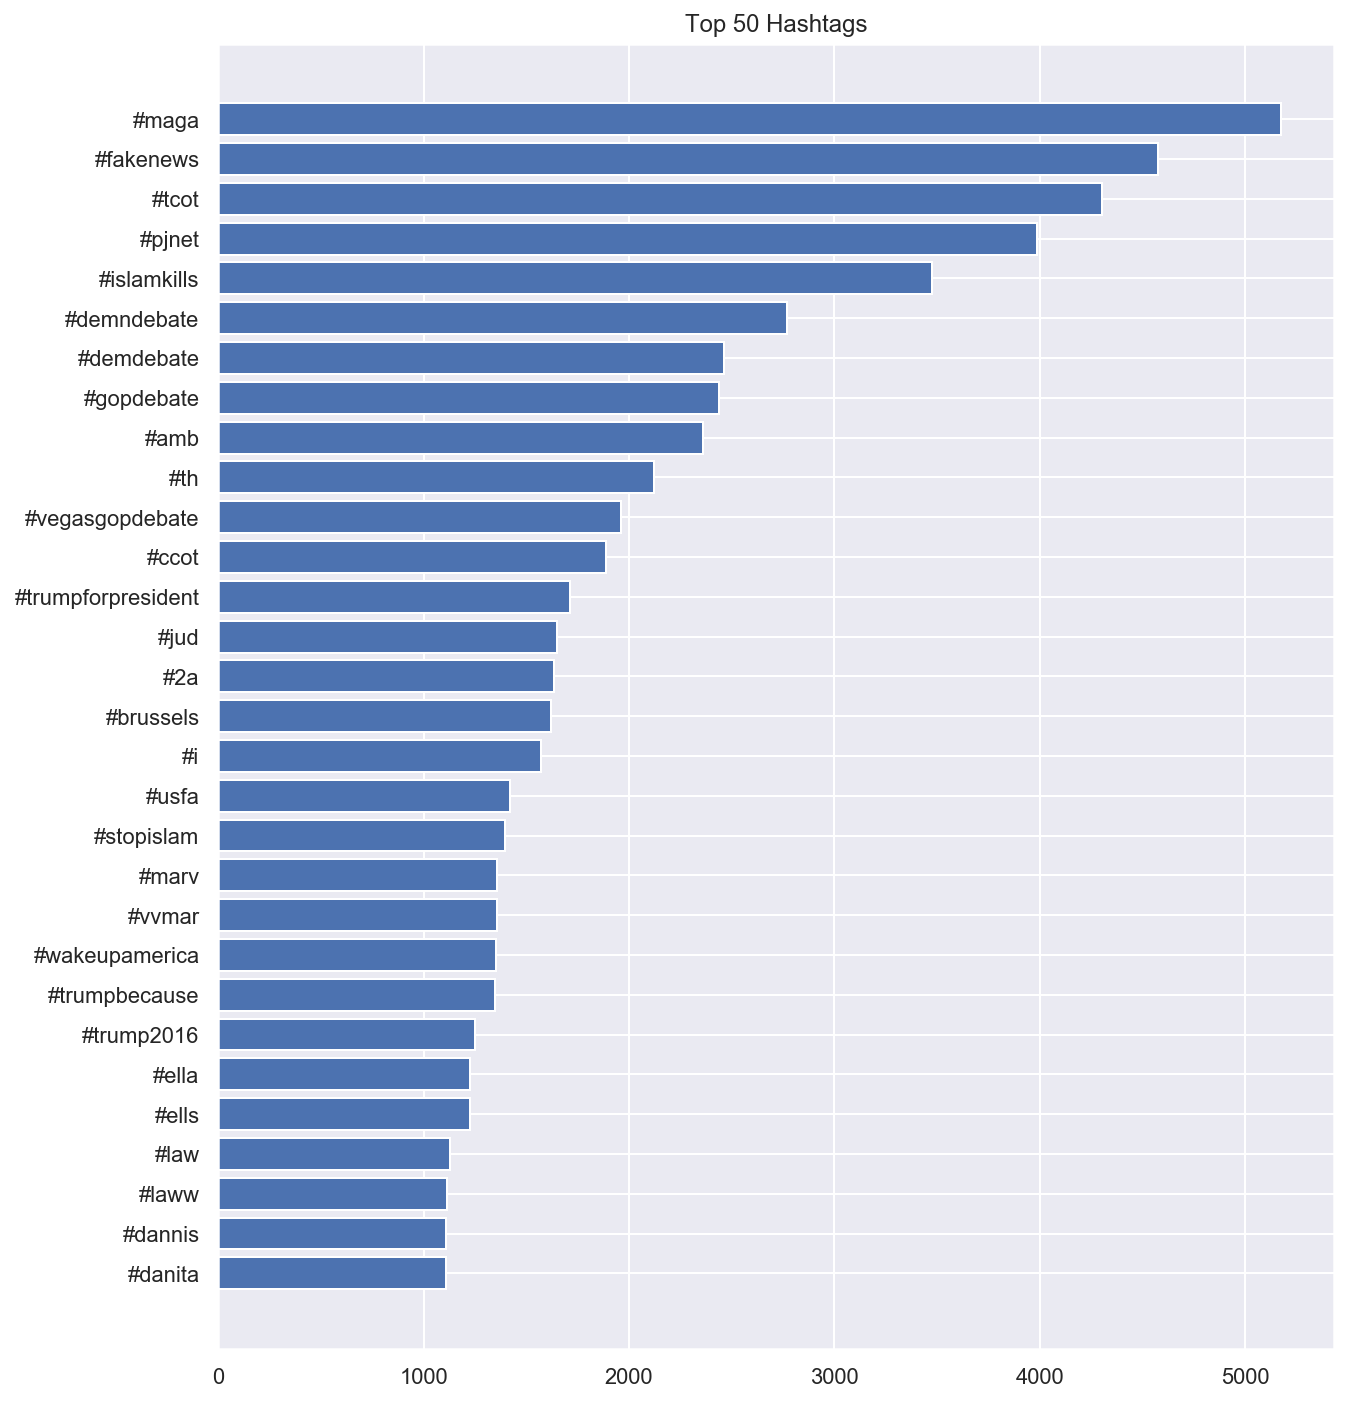

In [74]:
topht = pd.Series([x for doc in hashtags for x in doc]).value_counts()
_, ht_ax = plt.subplots(figsize=(10, 12))
ht_ax.barh(topht.index[:30][::-1], topht[:30][::-1])
plt.title('Top 50 Hashtags')
plt.show()

#### Topic Modeling

In [76]:
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
print('Before:', len(dictionary))
dictionary.filter_extremes(no_below=10, no_above=.20)
print('After:', len(dictionary))

Before: 97000
After: 16562


In [79]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [77]:
hdictionary = Dictionary(hashtags)
hdictionary.filter_extremes(no_below=5, no_above=.15)

In [78]:
hcorpus = [hdictionary.doc2bow(doc) for doc in hashtags]

In [97]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [98]:
%%time
from gensim.models import LdaModel
model = LdaModel(corpus=corpus,
                 id2word=dictionary,
                 num_topics=5,
                 passes=10,
                 iterations=500)

CPU times: user 12min 25s, sys: 5.49 s, total: 12min 30s
Wall time: 13min 11s


In [99]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook() 

In [101]:
pdata = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [102]:
print('10 passes, rdata all words')
pyLDAvis.display(pdata)

10 passes, rdata all words


In [96]:
pyLDAvis.display(pdata)

In [92]:
pyLDAvis.display(pdata)

In [85]:
pyLDAvis.display(pdata)

In [103]:
def get_topicdocs(model, corpus):
    topicdocs = np.zeros((len(corpus), model.num_topics))
    for idoc, doc in enumerate(model[corpus]):
        for it in doc:
            topicdocs[idoc, it[0]] = it[1]
    return topicdocs

In [104]:
topicdocs = get_topicdocs(model, corpus)

In [105]:
top10 = topicdocs.argsort(axis=0)[-10:][::-1]

In [143]:
topic = 2
print(f'Top tweets for topic {topic}:\n')
for tweet in rdata.content.values[top10[:,topic]]:
    print(tweet, '\n')

Top tweets for topic 2:

Hillary is a giant piece of ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©ð©#280characters https://t.co/P58vHF3aZs 

I'd like to see this one day @realDonaldTrump  #Trump #GOP #conservative #republican #America #USA #patriots https://t.co/xXC5TZpe6E 

Why would anyone who hates America as much as Obama want to be POTUS. Think people, think. Love of country is not it. @Fgarcia2849Jr 

Why would anyone who hates America as much as Obama want to be POTUS. Think people, think. Love of country is not it. @Fgarcia2849Jr 

Be patient, one day someone is going to walk into your life and make you 

In [ ]:
for tweet in text.values[thinds]:
    print(tweet)

In [274]:
thinds = []
for idoc, doc in enumerate(docs):
    if '#th' in doc:
        thinds.append(idoc)

#### Word Vectors

In [14]:
TEXT = 'train.txt'

In [16]:
train_text = "\n".join([" ".join(doc) for doc in docs])

In [17]:
import codecs
file = codecs.open(TEXT, 'w', 'utf-8')
file.write(train_text)
file.close()

In [37]:
from fastText import train_unsupervised
ft_model = train_unsupervised(TEXT, dim=25, epoch=10)

In [38]:
reps = np.array([ft_model.get_sentence_vector(' '.join(doc)) for doc in docs])

In [67]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(perplexity=50)
# tsne = PCA(n_components=10)
sample_inds = np.random.choice(len(reps), 1000)
proj = tsne.fit_transform(reps[sample_inds])

In [68]:
cats = pd.Series(data.account_category.values[sample_inds], dtype='category')

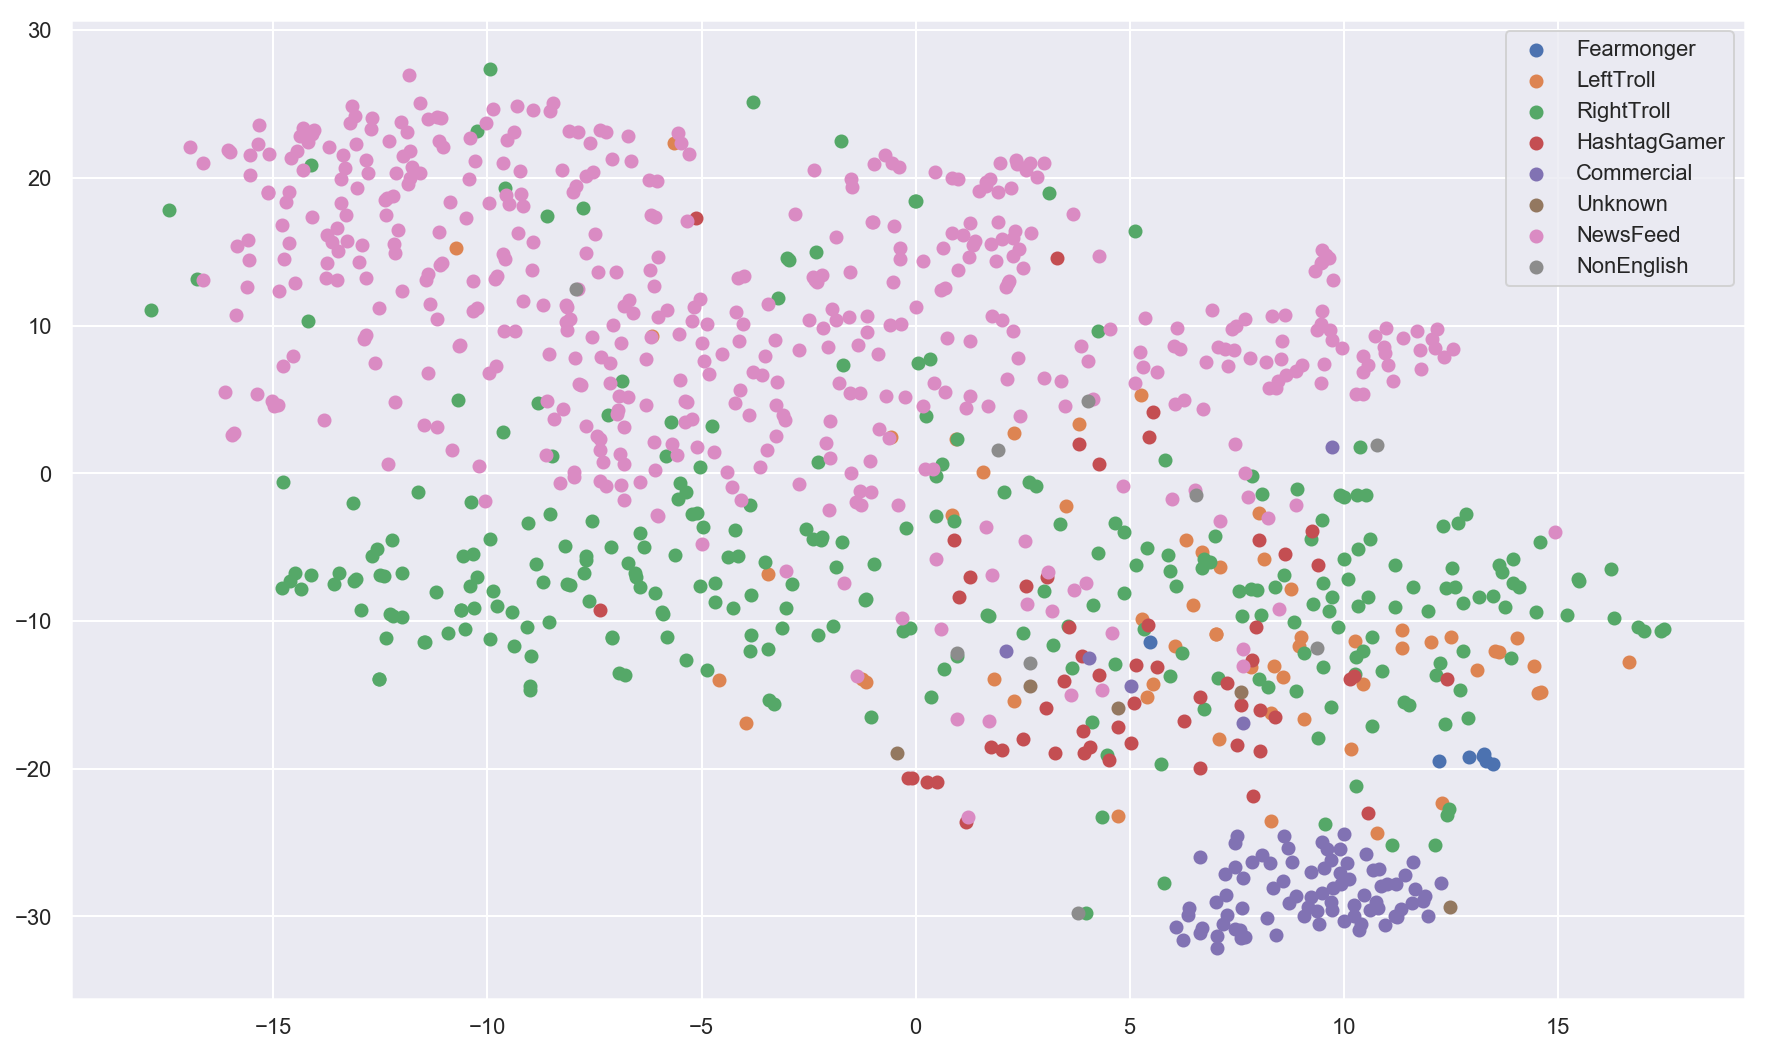

In [71]:
_, tsne_ax = plt.subplots(figsize=(15, 9))
for cat in set(cats.values):
    tsne_ax.scatter(*proj[cats == cat][:,[0,1]].T, label=cat)
plt.legend()
plt.show()